# Homework 6, exercise 4
## Implementation of Simon's algorithm

In [1]:
import numpy as np 
%matplotlib inline

P = np.array([
    [1, 0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1]
])

n = 7
k = 4

To solve the problem, we implement Simon's algorithm with oracle for  $f: \mathbb{F}_2^n \to \mathbb{F}_2^{n - k}$, $f(v) = P \cdot v$. Indeed, then $v_1 - v_2 \in H$ iff $P\cdot(v_1 - v_2) = 0 \Leftrightarrow f(v_1) = f(v_2)$. Therefore:

(a) Circuit for Simon's quantum algorithm consists of $n + (n - k)$ qubits, i.e. 10 in our case.

(b) First $n$, i.e. 7 in our case, qubits will be measured.

## Circuit construction

The main challenge is to construct the oracle $U_f$.<br> For $ v \in \mathbb{F}^n_2$ and $ y  \in \mathbb{F}^{n-k}_2$, it should act as $U_f \left( \left| v \right\rangle \otimes   \left| y \right\rangle \right) = \left| v \right\rangle \otimes   \left| y  + P \cdot v \right\rangle $.

Let's label rows of $P$ as $ \begin{bmatrix}  p^\top_1 \\ \vdots \\ p^\top_{n - k} \end{bmatrix}$. Then, the $i$-th element of vector $ P \cdot v  $ can be presented as $ p^\top_i v$, where $ i \in \overline{1, n - k}$. Denoting elements of vectors like: $p_i = \left(p_{i1}, \dots, p_{in} \right)$ and $v = \left(v_1, \dots, v_n \right)$, it can be written as:
$$
p^\top_i v = \sum^n_{j = 1} p_{ij} v_j = \sum_{j \in \overline{1, n} : \;p_{ij} = 1} v_j.
$$

Thus, to obtain $(n + i)$-th qubit of oracle output, i.e. $y_i + p^\top_i v  = y_i + \sum_{j \in \overline{1, n} : \;p_{ij} = 1} v_j$, we can apply sequence of $\text{CNOT}$ operations with $j$-th qubit as control one and $n + i$-th as target one for $j \in \overline{1, n}$ s.t. $p_{ij} = 1$.

The full circuit with this oracle is:

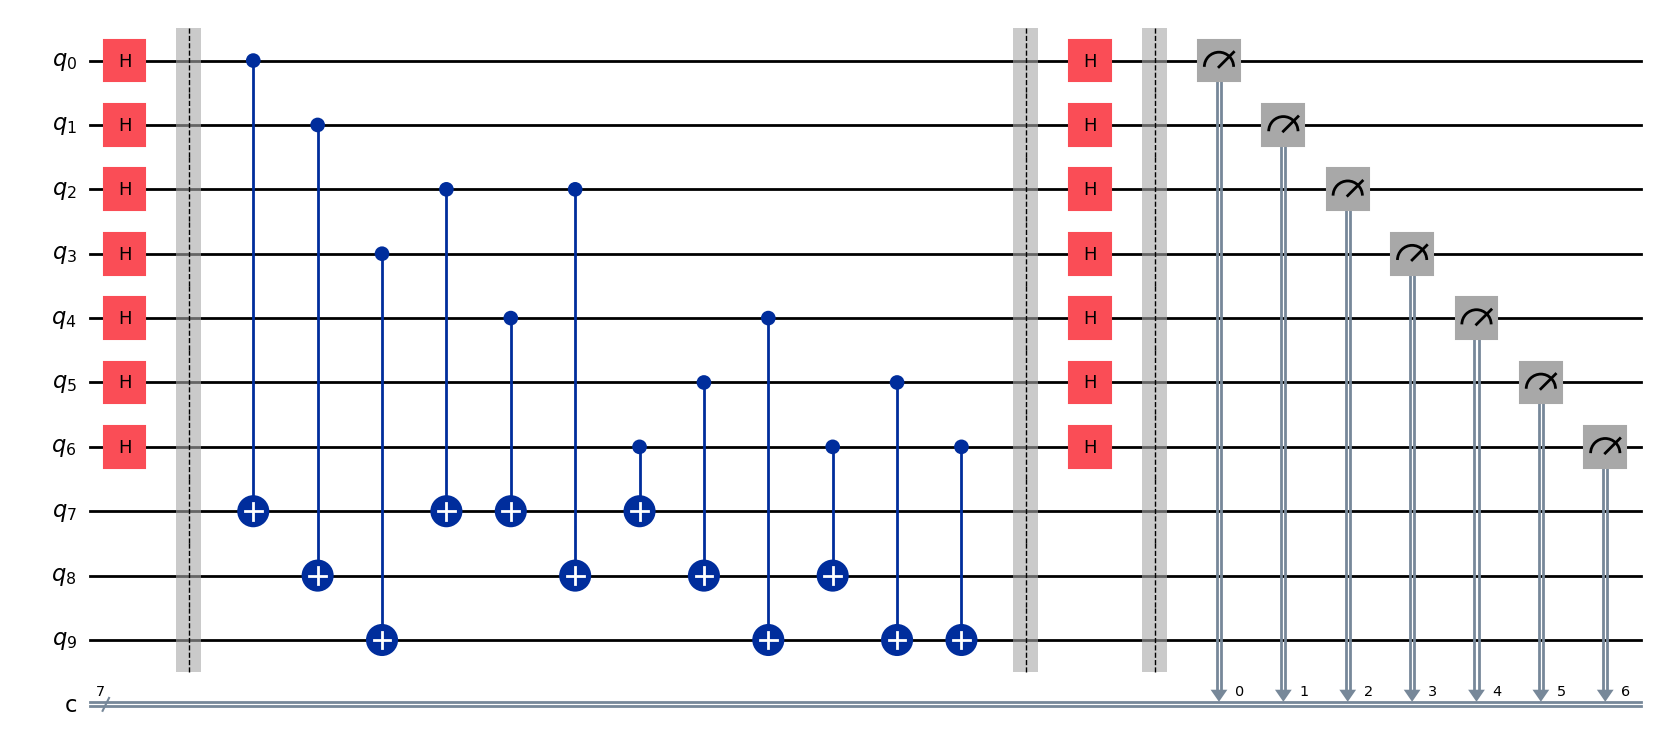

In [2]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(n + (n - k), n) 
circuit.h(np.arange(n))
circuit.barrier()

for i in range(n - k):
    circuit.cx(P[i].nonzero()[0], n + i)
circuit.barrier()

circuit.h(np.arange(n))
circuit.barrier()

circuit.measure(np.arange(n), np.arange(n))
circuit.draw('mpl')

## Running the algorithm

(c) As the basis consists of $n - k$ vectors, we need at least $n - k$, i.e. 3 shots. With probability greater than $\frac{1}{4}$, these will be enough to recover the basis. In case of failure, we can repeat the experiment multiple times.

In the codeblock below, we create a function which returns the vectors obtained by measuring result $n - k$ times.

In [3]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()

def run_simulation(simulator, circuit, n, k):
    job = simulator.run(circuit, shots=n - k)  # launch a job to run the circuit multiple times
    result = job.result()  # obtain results of a run
    counts = result.get_counts()  # obtain results of the measumerents
    vectors = [list(map(lambda x: int(x), v))[::-1] for v in counts.keys()]
    return vectors

(d) Here, we verify whether the result contains $n - k$ linearly independent vectors or not and repeat the experiment until success.

Linear independence of vectors is tested by using Gaussian elimination method over field $\mathbb{F}_2$.

In [4]:
import sympy

n_exp = 0
x_final = None
while x_final is None:
    x = run_simulation(simulator, circuit, n, k)
    n_exp += 1
    if len(x) < n - k:
        continue
    x = sympy.Matrix(x)
    if len(x.rref(iszerofunc=lambda x: x % 2 == 0)[1]) < n - k:
        continue
    x_final = x

x_final = np.array(x_final)
print('Solution found after', n_exp, 'trials.')
print('Basis:', x_final, sep='\n')

Solution found after 2 trials.
Basis:
[[1 1 0 1 0 0 1]
 [0 1 1 0 0 1 1]
 [1 1 0 0 1 1 0]]


## Results verification

(e)

In [5]:
H = np.array([
    [1, 1, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 1, 0, 1, 0],
    [1, 1, 0, 1, 0, 0, 1]
])

np.any(H @ x_final.T % 2) == 0

True

Indeed, we can see that the found vectors are orthogonal to basis vectors of space $H$.